<center><h1> Final Project</center>

<center><h3> Set Operations on Counting Bloom Filters for New York Taxi Rides

<center>Michelle Hackl

<center> CS110

<center> Professor Sterne

---

<center><h2> Introduction

In this paper I will be exploring the possibility of applying set operations to two or more Counting Bloom Filter objects to do data queries. Using data from the publicly available New York taxi rides dataset of January 2017, I simulate 4 different taxi companies' rides on a single afternoon. I then use union, intersection and difference operations to query the Bloom Filters and make inferences about the areal overlap between the four companies and what routes were most visited during that time. 

With the current setup of my Counting Bloom Filter as a bitarray, it is limited to no more than 255 counts in a single slot of the array. Because of the nature of the set operations, subtracting or adding one array to another, I have chosen not to implement a collision function, as this would break the 1-to-1 correspondence between the stored slots for objects in both filters. For the sake of storage, the Counting Bloom Filter could also store values in integer format (as my original code did), but that would greatly reduce the storage benefits for which we chose to use a Bloom Filter in the first place. An explanation of how the set operations work on Counting Bloom Filters follows below.

---

<center> <h2> Counting Bloom Filter


In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
import sys
import random
import string
import numpy as np
import pandas as pd
import pymmh3 as mmh3
from math import log, pow, exp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pd.options.mode.chained_assignment = None

In [2]:
# Note: This code was partially reused from my previous assignment 
#       (and modified to include the changes you suggested!)

def mmhash(key):
    return mmh3.hash(key, seed = 1)


class CountingBloom:
    
    def __init__(self, items, k, fp_rate, set_op=False, bits=None):
        """
        Calculates desired array size as a function of k,
        number of items to be stored and the desired fp_rate
        and ensures that self.bits is assigned a prime number.
        
        Note that objects created by the set operations do not
        have the correct items count! Hence, by calling the count
        function on them later they are identified as such and the
        count is calculated from the items in the array directly.
        """
        if bits == None:
            bits = (- items * k) / log(1 - fp_rate**(1 / float(k)))
            bits = int(round(bits))
            while not all(bits % i for i in xrange(2, bits)):
                bits += 1
   
        self.bits = bits # number of bits in the array
        self.fp_rate = fp_rate 
        self.k = k # number of hash functions to be used
        self.ideal_items = items
        self.set_op = set_op
        self.items = 0 # number of items already stored
        self.array = [] 
        self.zero_array()
        
        
    def zero_array(self):
        """
        Initializing the array.
        """
        self.array = bytearray(self.bits)
         
            
    def get_hash_indexes(self, key):
        """
        Double hashes the key k times and returns
        a list of indexes for the key.
        """
        index_list = []  
        for i in range(1, self.k + 1):
            index_list.append((hash(key) + i * mmhash(key)) % self.bits)
        return index_list
    
    
    def add(self, key):
        """
        Takes the k indexes that the hash produces
        and increments all of them once. Also increases
        total item count. If zero_array initializes to 
        bytearray, only 255 items can be stored per slot.
        """
        for i in self.get_hash_indexes(key):
            self.array[i] += 1
            if self.array[i] >= 250:
                print "Careful, this array is getting pretty full."
        self.items += 1
        
        
    def remove(self, key):
        """
        Like self.add, but decrements counts instead.
        """
        for i in self.get_hash_indexes(key):
            self.array[i] -= 1
        self.items -= 1
        
        
    def member(self, key):
        """
        Checks if the item exists in the array. 
        """
        for i in self.get_hash_indexes(key):
            if self.array[i] <= 0:
                return False
        return True
    
    
    def count(self, key):
        """
        Returns lowest count of all k hash indexes. If
        keys don't overlap significantly, this should 
        accurately represent the key count.
        
        Checks if the object was created by set operations,
        and if so, updates its self.items counter to the 
        correct number and removes the set_op tag.
        """
        if self.set_op == True:
            self.items = sum(self.array)/self.k
            self.set_op = False
        
        temp_min = self.bits
        if self.member:
            for i in self.get_hash_indexes(key):
                if self.array[i] < temp_min:
                    temp_min = self.array[i]
            return temp_min
        else:
            return 0
        

---

<center><h2> Data Cleaning

These are New York taxi and limousine rides for the month of January 2017 (of only one kind of taxi company out of the most popular 3!). I start by removing all additional columns besides pickup and dropoff location, as these are the only details I want to encode in my Bloom Filter for now. If I wanted to do queries on times, driver IDs or prices, for example, I would have to store that data in a seperate Filter. Not the most efficient way to query data, but for demonstrative purposes it is sufficient.

Data retrieved from http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml

In [3]:
data = pd.read_csv('green_tripdata_2017-01.csv')

In [4]:
print data.tail(2)

         VendorID lpep_pickup_datetime lpep_dropoff_datetime  \
1070259         1  2017-01-31 23:00:15   2017-01-31 23:10:07   
1070260         1  2017-01-31 23:00:12   2017-01-31 23:04:19   

        store_and_fwd_flag  RatecodeID  PULocationID  DOLocationID  \
1070259                  N           1            82            56   
1070260                  N           1           244           244   

         passenger_count  trip_distance  fare_amount  extra  mta_tax  \
1070259                1            2.2          9.0    0.5      0.5   
1070260                1            0.7          5.0    0.5      0.5   

         tip_amount  tolls_amount  ehail_fee  improvement_surcharge  \
1070259         0.0           0.0        NaN                    0.3   
1070260         1.0           0.0        NaN                    0.3   

         total_amount  payment_type  trip_type  
1070259          10.3             2          1  
1070260           7.3             1          1  


In [5]:
location_data = data[['PULocationID', 'DOLocationID']]
loc_data_counters = (location_data.groupby(['PULocationID', 'DOLocationID'])
                     .size().reset_index(name='Count'))
print loc_data_counters.tail(5)

       PULocationID  DOLocationID  Count
17742           265           248      1
17743           265           259      1
17744           265           262      1
17745           265           264      8
17746           265           265    259


There are more than 17.000 different combinations of pickup and dropoff locations within this data set alone. We want to reduce this to a number that will allow us to make actual inferences about our data, since we are not concerned with what exact street corner every pickup happened. Here I import the zone lookup file that shows the correspondence of each location ID to one of New York's 5 boroughs (+ 1 special zone for the airport). I have further split each of these in 2-5 sub-groups based on the secondary location information (not displayed here). Let's replace the 265 pickup and dropoff location numbers with those more general areas, for legibility purposes. 

In [6]:
zone_lookup = pd.read_csv('taxi+_zone_lookup.csv')
zone_lookup = zone_lookup[['LocationID', 'Borough']]
print zone_lookup.head(7)

   LocationID         Borough
0           1             EWR
1           2         Queens1
2           3          Bronx1
3           4      Manhattan1
4           5  Staten Island1
5           6  Staten Island1
6           7         Queens1


In [7]:
dic = {x: y for x, y in zip(zone_lookup['LocationID'], zone_lookup['Borough'])}

location_data['PULocationID'] = location_data['PULocationID'].map(dic)
location_data['DOLocationID'] = location_data['DOLocationID'].map(dic)

In [8]:
new_loc_data_counters = (location_data.groupby(['PULocationID', 'DOLocationID'])
                         .size().reset_index(name='Count'))

print new_loc_data_counters.tail(5)

       PULocationID    DOLocationID  Count
475  Staten Island2             EWR      3
476  Staten Island2      Manhattan5      1
477  Staten Island2         Queens3      1
478  Staten Island2  Staten Island1     15
479  Staten Island2  Staten Island2     69


Looks a lot better already! Now we have less than 500 distinct pickup-dropoff area correspondences for our roughly 1 million different rides. This should allow us to see where different taxi companies overlap and if any of them have privileges over a certain area that others might not. Below I have also created a list that holds the strings for all possible pickup-dropoff combinations. I use it later to "undo" the hashing of the set operation objects and print out the areas within them. While being originally concerned that such a function would take n^2 time (by permuting every pickup and every dropoff location and then checking for membership of each), by taking it directly from the location data counter here, I only lookup those permutations that actually exist and so reduced the lookups from 70.000+ to less than 500.

In [9]:
lookup_permutations = []
for i in range(len(new_loc_data_counters)):
    lookup_permutations.append((str(new_loc_data_counters["PULocationID"][i]+
                                str(new_loc_data_counters["DOLocationID"][i]))))

---

<center><h2> Set Operations on Counting Bloom Filters

Now we want to code up set operations for two Counting Bloom Filter objects to use them for data analysis later. Specificially we want to be able to get the union, intersection and difference between two filters. All operations work with relatively simple list comprehension, either adding, subtracting or taking the minimum of the two arrays in any given slot.

Images retrieved from https://www.probabilitycourse.com/chapter1/1_2_2_set_operations.php

References for set operations retrieved from https://blog.demofox.org/2015/02/08/estimating-set-membership-with-a-bloom-filter/

In [10]:
union = mpimg.imread('union.png')
difference = mpimg.imread('difference.png')
intersection = mpimg.imread('intersection.png')

**Union:** The first operation that we want our Bloom Filters to do is return a union of two filters, meaning a new Bloom Filter object that holds only those items that are unique to both of the original arrays. Given the fact that we do not only have traditional Bloom Filters, where the union would simply mean all possible items, but that a Counting Bloom Filter has a count of those items too, the union function has received an additional argument *total*, that determines whether it should return a simple union or a total union. 

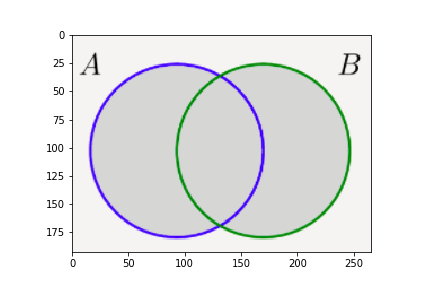

In [11]:
imgplot_union = plt.imshow(union)
plt.show()

**Intersection:** The intersection of our two Bloom Filters is simply all the items that the two sets have in common, including only the *amount* of each item that they have in common. This works by taking the minimum number of each slot in the two arrays. Additionally, this function checks to see if the returned Bloom Filter object is empty, which would imply that the two sets are disjoint and do not share any common rides.

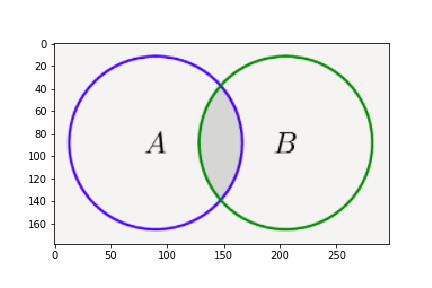

In [12]:
imgplot_intersect = plt.imshow(intersection)
plt.show()

**Difference:** The difference function shows items unique to either set A (A-B) or set B(B-A). It is notable here that the order in which arguments are passed in matters for the function to return the correct subset of the data. As I will demonstrate below the next section of code, this function can actually create *false negatives*, which the other two cannot. This is because if overlap between two hashed items exists this function cannot differentiate between which item the count came from and hence deletes both of them. When later searching for an item at the corresponding k slots, only k-1 or less of them will be filled and a false negative returned. To avoid this issue, the number of hash functions can be reduced and the size of the array increased to avoid overlaps as much as possible.

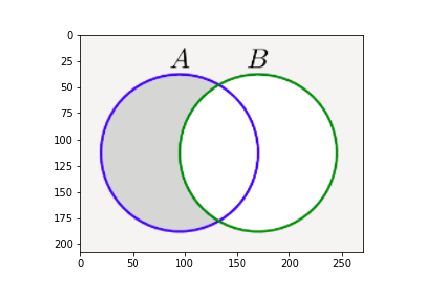

In [13]:
imgplot_diff = plt.imshow(difference)
plt.show()

In [14]:
def union(bloom1, bloom2, total=None):
    """
    Returns either a simple union (just a list of existing
    items in both filters) or a total one (all existing items
    together with their total count).
    """
    if bloom1.bits != bloom2.bits:
        print "Your bloom filters must have the same size."
        return 0
    elif bloom1.k != bloom2.k:
        print "Unequal number of hash functions."
        return 0
    else:
        union_bloom = CountingBloom(bloom1.ideal_items, bloom1.k,
                                    bloom1.fp_rate, True)
        sum_blooms = [x1 + x2 for (x1, x2) in zip(bloom1.array, bloom2.array)]
        if total != None:
            union_bloom.array = sum_blooms
            print "Returning a total union."
        else:
            union_bloom.array = [1 if (x > 0) else 0 for x in sum_blooms]
            print "Returning a simple union."
        return union_bloom
    
def intersection(bloom1, bloom2):
    """
    Calculates where the two sets intersect and,
    if given, if they are disjoint or not.
    """
    if bloom1.bits != bloom2.bits:
        print "Your bloom filters must have the same size."
        return 0
    elif bloom1.k != bloom2.k:
        print "Unequal number of hash functions."
        return 0
    else:
        intersect_bloom = CountingBloom(bloom1.ideal_items, bloom1.k,
                                        bloom1.fp_rate, True)
        intersect_bloom.array = [min(x1, x2) for (x1, x2) in
                                 zip(bloom1.array, bloom2.array)]
        if all([x == 0 for x in intersect_bloom.array]):
            print "These two sets are disjoint!"
        return intersect_bloom
    
def difference(bloom1, bloom2):
    """
    Returns the items unique to bloom1. Note that
    this can create false negatives if items overlap.
    """
    if bloom1.bits != bloom2.bits:
        print "Your bloom filters must have the same size."
        return 0
    elif bloom1.k != bloom2.k:
        print "Unequal number of hash functions."
        return 0
    else:
        intersect_bloom = CountingBloom(bloom1.ideal_items, bloom1.k,
                                        bloom1.fp_rate, True)
        intersect_bloom.array = [x1-x2 if (x1-x2 >= 0) else 0 for (x1, x2)
                                 in zip(bloom1.array, bloom2.array)]
        return intersect_bloom    
    
def unhash_print(bloom, lookup, count):
    """
    Checks for membership of all lookup strings in
    the filter and returns those that exist more 
    than the number of count (to avoid printing a 
    giant list.)
    """
    for route in lookup:
        if bloom.member(route) and bloom.count(route) >= count:
            print str(bloom.count(route)) + "x " + str(route)

In [15]:
taxi1 = CountingBloom(3, 4, 0.05)
taxi2 = CountingBloom(3, 4, 0.05)

for _ in range(3):
    taxi1.add("hello")
    taxi1.add("goodbye")
    taxi1.add("steven")
    taxi2.add("hello")
    taxi2.add("goodbye")
    taxi2.add("george")
    
taxi_union_simple = union(taxi1, taxi2)
taxi_union_total = union(taxi1, taxi2, total="yes")
taxi_intersection = intersection(taxi1, taxi2)
taxi_diff_1_to_2 = difference(taxi1, taxi2)
taxi_diff_2_to_1 = difference(taxi2, taxi1)
print "Initial1: " + str(taxi1.array)
print "Initial2: " + str(taxi2.array)
print "Union_si: " + str(taxi_union_simple.array)
print "Union_to: " + str(taxi_union_total.array)
print "Intersec: " + str(taxi_intersection.array)
print "Diff_1o2: " + str(taxi_diff_1_to_2.array)
print "Diff_2o1: " + str(taxi_diff_2_to_1.array)
print "_________"

print taxi_diff_1_to_2.member('steven')
print taxi_diff_1_to_2.member('hello')
print taxi_diff_1_to_2.member('george')

print taxi_diff_2_to_1.member('steven')
print taxi_diff_2_to_1.member('hello')
print taxi_diff_2_to_1.member('george')

Returning a simple union.
Returning a total union.
Initial1:           
Initial2:         	  
Union_si: [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0]
Union_to: [0, 6, 3, 0, 0, 6, 6, 3, 12, 0, 0, 0, 6, 9, 0, 3, 15, 3, 0]
Intersec: [0, 3, 0, 0, 0, 3, 3, 0, 6, 0, 0, 0, 3, 3, 0, 0, 6, 0, 0]
Diff_1o2: [0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0]
Diff_2o1: [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0]
_________
False
False
False
False
False
False


Above a short demonstration of what all operations look like on the array. Note that the initial objects are not printed out because they are bitarrays. Only the set operated objects have normal arrays and can hence be printed. Note that when testing for all items in the sets that hold only the differences between 1 and 2, all memberships return False. In realtiy, however, "steven" is unique to the first set and "george" unique to the second set. As mentioned above, we can avoid such a false negative by reducing the allowed error rate and reducing the number of hash functions to avoid collision:

In [16]:
taxi1 = CountingBloom(3, 2, 0.01)
taxi2 = CountingBloom(3, 2, 0.01)

for _ in range(3):
    taxi1.add("hello")
    taxi1.add("goodbye")
    taxi1.add("steven")
    taxi2.add("hello")
    taxi2.add("goodbye")
    taxi2.add("george")
    
taxi_diff_1_to_2 = difference(taxi1, taxi2)
taxi_diff_2_to_1 = difference(taxi2, taxi1)

print taxi_diff_1_to_2.member('steven')
print taxi_diff_1_to_2.member('hello')
print taxi_diff_1_to_2.member('george')

print taxi_diff_2_to_1.member('steven')
print taxi_diff_2_to_1.member('hello')
print taxi_diff_2_to_1.member('george')

True
False
False
False
False
True


---

<center><h2> Taxi Companies

Now let's create some taxi companies and see if we can assign them data for rides they provided.

In [17]:
print location_data.tail(3)

        PULocationID DOLocationID
1070258    Brooklyn3      Queens3
1070259      Queens2      Queens2
1070260   Manhattan5   Manhattan5


In [18]:
green_taxi = CountingBloom(500, 2, 0.005)
yellow_taxi = CountingBloom(500, 2, 0.005)
blue_taxi = CountingBloom(500, 2, 0.005)
red_taxi = CountingBloom(500, 2, 0.005)

I have reduced the number of hash functions to reduce the error of the set differences. Given the size limitations of our bitarray, we can assign each company 1700 different rides, roughly what they would do on a Saturday afternoon.

In [19]:
taxi_companies = [green_taxi, yellow_taxi, blue_taxi, red_taxi]
color = ["green", "yellow", "blue", "red"]

items = 1700

for (i, company) in enumerate(taxi_companies):
    for j in range(items*i, items*(i*2)):
        ride_code = (str(location_data['PULocationID'][j]) +
                     str(location_data['DOLocationID'][j]))
        company.add(ride_code)
        

Knowing nothing else about the rides we have just assigned those companies, we would expect there to be some overlap between them and some areas that they mostly cover by themselves, so we would expect their venn diagram to look something like this one:

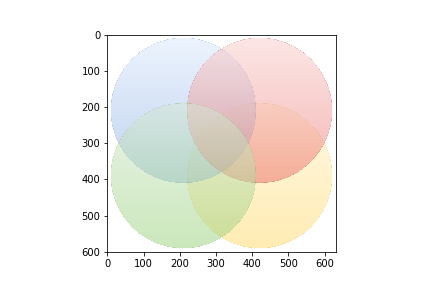

In [20]:
original_ven = mpimg.imread('original_overlap.png')
imgplot = plt.imshow(original_ven)
plt.show()

Now let's look at what kind of queries we can make with these taxi companies for our made up Saturday afternoon.
First thing first, I was planning on ordering a cab for my cousing, coming in from the airport next Saturday, so let's use this Saturday's data as a proxy. She has not yet decided where she is going to stay, so let's say we want to know if taxis cover the way to either a hotel in the Bronx, a suite in Queens or a different hotel in Manhatten are. These are located in the following areas:
- Bronx1
- Queens3
- Manhatten2

In [21]:
airport_lookup = ["EWRBronx3", "EWRQueens3", "EWRManhatten2"]

union_rides = union(yellow_taxi, union(red_taxi,
                    union(blue_taxi, green_taxi)))
unhash_print(union_rides, airport_lookup, 0)

Returning a simple union.
Returning a simple union.
Returning a simple union.
1x EWRBronx3
1x EWRQueens3


Looks like some taxis were going to two of those neighborhoods! Now I would also like to get a feel for how busy those times are at the airport.

In [22]:
total_rides = (union(yellow_taxi, union(red_taxi, union(blue_taxi,
               green_taxi, total="yes"), total="yes"), total="yes"))
unhash_print(total_rides, airport_lookup, 0)

Returning a total union.
Returning a total union.
Returning a total union.
2x EWRBronx3
2x EWRQueens3


Two each, so not that busy after all. How about the total traffic in Staten Island only?

In [23]:
staten_island_lookup = ['StatenIsland1StatenIsland1','StatenIsland1StatenIsland2',
                        'StatenIsland2StatenIsland1','StatenIsland2StatenIsland2']
print unhash_print(total_rides, staten_island_lookup, 0)

None


No one! Guess people don't want to stay around the island after all. Now, since my other cousin has been thinking about starting to ride his Uber in a new area, that he hopes will pay better, I'd like to know what the most popular taxi terriorty is. Let's look for places that all of the companies go to!

In [24]:
most_wanted = intersection(green_taxi, intersection(yellow_taxi,
                            intersection(red_taxi, blue_taxi)))

These two sets are disjoint!


Looks like some of these taxi companies don't overlap at all! Let's have a closer look at that.


In [25]:
for (color_1,company) in zip(color, taxi_companies):
    for (color_2, other_company) in zip(color, taxi_companies):
        if company != other_company:
            print color_1 + " and " + color_2
            intersect = intersection(company, other_company)
            unhash_print(intersect, lookup_permutations, 65)
            
            

green and yellow
These two sets are disjoint!
green and blue
These two sets are disjoint!
green and red
These two sets are disjoint!
yellow and green
These two sets are disjoint!
yellow and blue
135x Manhattan1Manhattan1
yellow and red
135x Manhattan1Manhattan1
blue and green
These two sets are disjoint!
blue and yellow
135x Manhattan1Manhattan1
blue and red
72x Brooklyn2Brooklyn2
67x Brooklyn5Brooklyn5
203x Manhattan1Manhattan1
92x Queens2Queens2
82x Queens2Queens3
86x Queens3Queens3
red and green
These two sets are disjoint!
red and yellow
135x Manhattan1Manhattan1
red and blue
72x Brooklyn2Brooklyn2
67x Brooklyn5Brooklyn5
203x Manhattan1Manhattan1
92x Queens2Queens2
82x Queens2Queens3
86x Queens3Queens3


Looks like Taxi Green has has their whole own territory on this nice Saturday afternoon, while Yellow is sharing some of the more popular spots with Blue and Red. And from the looks of it, Blue and Red are sharing more than 60% of their territory with each other! Maybe they should consider doing joint rides for such times, they might be able to cover the area more effectively with less cars. In reality, their overlap looks more something like this:

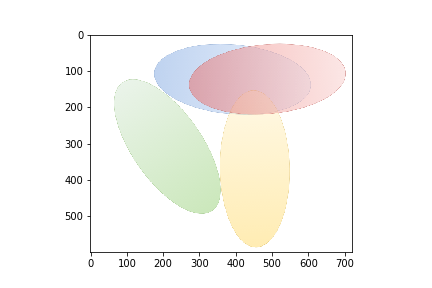

In [26]:
actual_ven = mpimg.imread('actual_overlap.png')
imgplot2 = plt.imshow(actual_ven)
plt.show()

Now that we know that Blue and Red share so much territory with one another, let's look at what they don't share.

In [27]:
unique_red = difference(red_taxi, blue_taxi)
unique_blue = difference(blue_taxi, red_taxi)

print "Unique to Red Taxi:"
unhash_print(unique_red, lookup_permutations, 40)

Unique to Red Taxi:
52x Brooklyn1Brooklyn1
43x Manhattan1Manhattan1
55x Queens2Queens2
56x Queens3Queens3


In [28]:
print "Unique to Blue Taxi:"
unhash_print(unique_blue, lookup_permutations, 1)

Unique to Blue Taxi:
1x Bronx1Bronx4
1x Bronx1Manhattan4
1x Bronx3Queens4
2x Bronx4Manhattan5
1x Bronx5Brooklyn2
1x Bronx5Manhattan1
1x Brooklyn1Manhattan2
1x Brooklyn1Staten Island2
1x Brooklyn2Queens1
1x Brooklyn3EWR
1x Brooklyn3Queens2
1x Brooklyn4EWR
2x Brooklyn5Queens2
1x EWRBrooklyn1
1x EWRBrooklyn4
1x EWRQueens2
1x Manhattan1Brooklyn3
2x Manhattan2Bronx1
2x Manhattan2Bronx3
1x Manhattan2Brooklyn1
1x Manhattan2EWR
1x Manhattan3Bronx2
2x Manhattan3Bronx3
2x Manhattan3Manhattan1
1x Manhattan3Queens1
3x Manhattan4Bronx2
1x Manhattan4Manhattan4
1x Manhattan5Bronx2
1x Manhattan5Queens2
1x Manhattan5Queens3
1x Queens1Bronx3
3x Queens1Brooklyn2
1x Queens1Brooklyn5
1x Queens2Bronx5
3x Queens2Manhattan4
1x Queens3Bronx2
2x Queens3Manhattan1
1x Queens3Manhattan4
1x Queens4Bronx2
1x Queens4Brooklyn1
1x Queens4Brooklyn4
1x Queens5Bronx4
2x Queens5Manhattan5


Looks like Red has some nice areas carved out for itself within Brooklyn, Manhatten and Queens, while Blue's unique routes are mostly those that go between different areas and are rather spread out. And that concludes our taxi querying for this lovely Saturday afternoon. Goodbye!